In [1]:
import pandas as pd
# Configure some display options for panda frames to ensure we see all columns and rows when needed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 6)
pd.set_option('display.max_colwidth', -1)

import datetime as dt

# Ensure we embedd the graphs we generate within the Notebook
%matplotlib inline


## Data Loading
Reading in the flatted json TSV. We can read the JSON files directly as well using Pandas. But this is a good example of how we can use multiple tools to do the data wrangling and preparation.

In [2]:
sensor_data = pd.read_csv('/media/sf_data/train_json/raw_train_json.tsv', header=None, sep='\t')

/opt/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15,16,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sensor_data.columns = [ 'exceededtransferlimit',
'objectid',
'globalid',
'wheelroll_id',
'serial_number',
'length',
'origin',
'destination',
'run_status',
'track_circuit',
'track_name',
'location',
'direction',
'station',
'platform',
'doors_open',
'at_platform',
'station_eta',
'current_pl',
'received_time',
'avg_dwell_latency',
'delta',
'delay_type',
'notes',
'station_arrival',
'state',
'serial_platform',
'id']

The table dimension are:

In [4]:
sensor_data.shape

(2577351, 28)

A preview is:

In [5]:
sensor_data.head()

,exceededtransferlimit,objectid,globalid,wheelroll_id,serial_number,length,origin,destination,run_status,track_circuit,track_name,location,direction,station,platform,doors_open,at_platform,station_eta,current_pl,received_time,avg_dwell_latency,delta,delay_type,notes,station_arrival,state,serial_platform,id
0,False,131,{1093486A-5D7F-4723-B5F3-8AB765A962D4},3730529,373.0,9,Y10,C85,Pending,C70R04,C1,C85,North,NaN,NaN,False,False,2017-05-10 14:40:27.000,2.0,2017-05-10 15:23:06.000,NaN,0.0,NaN,NaN,NaN,Moving,373,NaN
1,False,134,{CF0F00D9-1BC1-4803-9A75-1EC456FD3671},3770559,377.0,10,Y10,C85,Scheduled,A10J15,C3,K20,North,K30,K30-3,False,False,2017-05-10 14:40:30.000,2.0,2017-05-10 15:23:14.000,NaN,157.0,NaN,NaN,2017-05-10 02:17:48.000,Moving,377K30-3,NaN
2,False,137,{844D1DC5-1D24-4B1D-B38F-FF10E00D2C35},2291017,229.0,8,A90,R65,Scheduled,A75A07,A2,A77,North,A70,A70-2,False,False,2017-05-10 14:40:28.000,2.0,2017-05-10 15:23:09.000,NaN,0.0,NaN,NaN,NaN,Moving,229A70-2,NaN
3,False,140,{89EC03E4-8CF9-4C22-853E-B156FD39D0C0},3290642,503.0,9,M90,L35,Scheduled,M20D06,M2,M16,North,M16,M16-2,True,True,2017-05-10 14:40:06.000,2.0,2017-05-10 15:22:29.000,NaN,0.0,NaN,NaN,NaN,Door open,503M16-2,NaN
4,False,143,{FE66787F-C37C-411C-B6C9-6DD651073916},1070445,101.0,10,S20,M90,Scheduled,A80A03,A2,A80,North,A80,A80-2,False,True,2017-05-10 14:40:15.000,2.0,2017-05-10 15:22:42.000,NaN,0.0,NaN,NaN,NaN,Arrived,101A80-2,NaN


## Data Clean up and Filtering

Format cleanup
 * received_time - Every record will have a 'received_time' field in ISO8601 format. We will convert the string into the datetime type (this will come in handy later for filtering).
 * serial_number - Conver from float64 to int.

Filtering - we will also eliminate any entries where:
 * serial_number is missing (i.e. na)
 * wheelroll_id is missing (i.e.na)
 * state is not either 'Arrived' or 'Departed' 


In [6]:
sensor_data.dtypes

exceededtransferlimit    bool   
objectid                 int64  
globalid                 object 
wheelroll_id             object 
serial_number            float64
length                   int64  
origin                   object 
destination              object 
run_status               object 
track_circuit            object 
track_name               object 
location                 object 
direction                object 
station                  object 
platform                 object 
doors_open               object 
at_platform              object 
station_eta              object 
current_pl               float64
received_time            object 
avg_dwell_latency        float64
delta                    float64
delay_type               object 
notes                    float64
station_arrival          object 
state                    object 
serial_platform          object 
id                       float64
dtype: object

In [7]:
sensor_data['received_time'] = pd.to_datetime(sensor_data['received_time'], infer_datetime_format=True, errors='ignore')

In [8]:
sensor_data = sensor_data[(sensor_data.state == 'Arrived') | (sensor_data.state == 'Departed')]

In [9]:
sensor_data.dropna(subset=['serial_number', 'received_time', 'wheelroll_id'],inplace=True)

In [10]:
sensor_data.serial_number = sensor_data.serial_number.astype(int, errors='coerce')

Now we will group the entries by serial_number and order the entries by received_time. Since a train will maintain a serial_number during a run, we can assume that it is the same train until the wheelroll_id changes. 

In [11]:
g_serial_by_received = sensor_data.groupby(['serial_number']).apply(lambda x: x.sort_values('received_time'))

Lets verify that we have entries grouped by serial_number an ordered by received_time in each group.

In [12]:
g_serial_by_received.groupby('serial_number').head(5).head(50)[['wheelroll_id', 'serial_number', 'origin', 'destination', 'track_name', 'location', 'direction', 'station', 'received_time', 'state']]

wheelroll_id  serial_number origin destination  \
serial_number                                                          
1             225574   0011318      1              NaN    NaN          
              320191   0011847      1              NaN    NaN          
2             1837576  0021850      2              NaN    NaN          
              2495942  0021505      2              NaN    NaN          
              225922   0021319      2              NaN    NaN          
3             2071823  0031125      3              NaN    NaN          
              2246054  0031817      3              NaN    NaN          
              320917   0031853      3              NaN    NaN          
4             2545704  0041747      4              NaN    NaN          
5             19061    0050220      5              NaN    NaN          
              323714   0051859      5              NaN    NaN          
6             67736    0061631      6              NaN    NaN          
              393093   0060242      6              NaN    NaN          
7             2251640  0071826      7              NaN    NaN          
              2440751  0071445      7              NaN    NaN          
              88725    0070234      7              NaN    NaN          
              230075   0071334      7              NaN    NaN          
8             324924   0081905      8              NaN    NaN          
9             89405    0090237      9              NaN    NaN          
10            2059783  0100205      10             NaN    NaN          
              2448143  0101533      10             NaN    NaN          
              2498791  0101517      10             NaN    NaN          
              327883   0101919      10             NaN    NaN          
11            773939   0111501      11             NaN    NaN          
              88720    0110237      11             NaN    NaN          
              155394   0111231      11             NaN    NaN          
              556666   0111911      11             NaN    NaN          
12            245135   0120301      12             NaN    NaN          
13            796519   0131304      13             NaN    NaN          
              331029   0131933      13             NaN    NaN          
              348596   0131812      13             NaN    NaN          
14            244802   0140301      14             NaN    NaN          
              89072    0140239      14             NaN    NaN          
              232179   0141345      14             NaN    NaN          
              331342   0141937      14             NaN    NaN          
              348309   0141813      14             NaN    NaN          
15            233231   0151350      15             NaN    NaN          
16            340276   0162018      16             NaN    NaN          
              350321   0161819      16             NaN    NaN          
17            2359834  0170351      17             NaN    NaN          
              1993717  0171819      17             NaN    NaN          
              237100   0171400      17             NaN    NaN          
              351613   0171822      17             NaN    NaN          
18            2360171  0180351      18             NaN    NaN          
              2554950  0181820      18             NaN    NaN          
              160106   0181245      18             NaN    NaN          
20            951147   0201405      20             NaN    NaN          
              2375442  0201117      20             NaN    NaN          
21            245138   0210306      21             NaN    NaN          
              355712   0211835      21             NaN    NaN          

                      track_name location direction station  \
serial_number                                                 
1             225574   C1         C80      North     C80      
              320191   C1         C80      North     C80      
2             1837576  C1

## Generate Movement Pairs
Now that we have the dataset, we will go through the table for each serial_number, wheelroll_id and find station pairs with subsequent rows, to build up an indexed list of all train journeys between each stations that we have data for.

### First some Sanity Checks

Lets look at how many (Arrived, Departed) records do we find for each serial_number.

In [13]:
tmp2 = g_serial_by_received.groupby(g_serial_by_received.serial_number).agg(['count'])
tmp2.sort_index(inplace=True)
tmp2.columns = tmp2.columns.get_level_values(0)
tmp2 = tmp2['origin']
tmp2 = tmp2.reset_index()
tmp2.columns = ['serial_number', 'count']
tmp2.head(150).tail(10)

,serial_number,count
140,335,405
141,336,2
142,361,5283
143,363,5113
144,365,4655
145,367,5241
146,369,4420
147,371,5104
148,372,3
149,373,5176


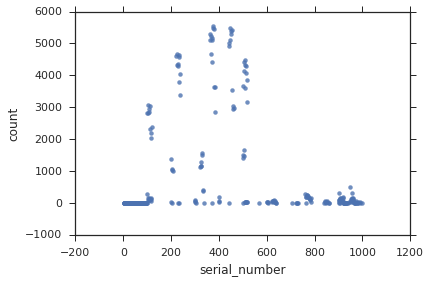

In [14]:
import seaborn as sns; sns.set(color_codes=True)

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

x = sns.regplot(x="serial_number", y="count", data=tmp2, fit_reg=False)


What is interesting is that there are some trains that have lot more runs and stops than others. Some are likely to be express trains. Other likely to run different shorter or longer routes.

Now we will loop through each group to build up the actual travel times dataset.

In [15]:
import numpy as np
from scipy import stats

In [16]:
class OutOfOrderTimes(RuntimeError):
    """Raised when we find records where row_a's received_time is after row_b's received_time."""
    pass

TIME_DELTA_24h = dt.timedelta(hours=24)

def is_suitable_for_travel_record(row_a, row_b):
    """Returns True if the following conditions are met:
      * serial_number and wheelroll_id match
      * location values are different
      * received_time for b 
      """
    if row_a['serial_number'] != row_b['serial_number']:
        # Until we clarify the interplay of serial_number and wheelroll_id, we will assume only identical serial records are comparable.
        return False
    if row_a['wheelroll_id'] != row_b['wheelroll_id']:
        # Until we clarify the effect of changing wheelroll_id, we will assume only identical ID are suitable.
        return False
    if row_a['location'] == row_b['location']:
        # This check ensures we don't create records between Arrived and Departed for the same station.
        return False
    
    time_diff = row_b['received_time'] - row_a['received_time']
    if time_diff > TIME_DELTA_24h:
        # This check ensure we are only considering entries within a 24hour period.
        return False
    
    if time_diff.total_seconds() < 0:
        message = "Error for serial_number={}, wheelroll_id={}, location_a={}, location_b={}, time_a={}, time_b={}".format(row_a['serial_number'], row_a['wheelroll_id'], row_a['location'], row_a['received_time'], row_b['received_time'])
        raise OutOfOrderTimes(message)
    return True

class TravelRecord(object):
    def __init__(self, row_a, row_b):
        """Represents a TravelRecord between two locations, including the start, end times as well as durations."""
        self._location_a = row_a['location']
        self._location_b = row_b['location']
        self._start_time = row_a['received_time']
        self._end_time = row_b['received_time']
        self._travel_time_secs = (self._end_time - self._start_time).total_seconds()
        
    def __str__(self):
        ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return ret
    
    def __repr__(self):
        #ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return self.__str__()

    #@staticmethod
    #def get_travel_times_stats(list_travel_records):
        #"""Given a list of TravelRecord objects, returns a DescribeResult object with stats on the travel time values"""
        ## 1. generate a list of travel times in a np. array
        #np_array = np.fromiter((x._travel_time_secs for x in list_travel_records), np.float)
        #return stats.describe(np_array)

In [17]:
def add_map_entry_a2b_list(map_to_update, key_a, key_b, list_entry):
    """Adds list_entry safely in the map for (key_a, key_b).
       If the list_entry is a list itself, it concatenates the list.
       Otherwise if it is an object, it appends to the existing list.
       """
    map_inner = dict()
    
    if key_a in map_to_update:
        # If a nested dict exists, we replace map_inner with it.
        map_inner = map_to_update[key_a]
    else:
        # If not, make sure we inject map_inner, or subsequent check for list will fail.
        map_to_update[key_a] = map_inner

    list_objects = list()
    if key_b in map_inner:
        # If a list exist, we replace list with it
        list_objects = map_inner[key_b]

    # Update the list
    if isinstance(list_entry, list):
        list_objects = list_objects + list_entry
    else:
        list_objects.append(list_entry)
        
    # Put it back in
    map_to_update[key_a][key_b] = list_objects

In [18]:
df_grouped = g_serial_by_received.groupby([g_serial_by_received.serial_number, 
                          g_serial_by_received.wheelroll_id]).apply(
                            lambda x: x.sort_values('received_time')
                          )

In [19]:
df_grouped.index.names

FrozenList([u'serial_number', u'wheelroll_id', None, None])

In [20]:
map_a2b_to_list_times = dict()

row_a = None
row_b = None

#
# Expectation - each row in the DataFrame has the following columns:
#  * serial_number
#  * wheelroll_id
#  * station
#  * received_time
#  * state
#
#
num_serial_numbers = 0
for (serial_number, wheelroll_id), group in df_grouped.groupby(level=[0,1]):
#for name, group in g_serial_by_received.groupby('serial_number'):
    #print "Processing serial_number={}".format(name)
    print ".",
    #print group[['wheelroll_id', 'serial_number', 'origin', 
    #             'destination', 'track_name', 'location', 'direction', 
    #             'station', 'received_time', 'state']].head(10)
    for index, row in group.iterrows():
        #print row['serial_number'], row['wheelroll_id'], row['location'], row['received_time'], row['state']
        if row_a is None:
            row_a = row
            # Skipping the rest of the processing
            continue
        elif row_b is None:
            row_b = row

            # Now do some processing on the record pair, IF the conditions are met
            if is_suitable_for_travel_record(row_a, row_b):
                travel_record = TravelRecord(row_a, row_b)
                
                add_map_entry_a2b_list(map_a2b_to_list_times, travel_record._location_a, 
                                       travel_record._location_b, travel_record)
            # Otherwise we simply skip this pair and advance the window
            # final step to advance
            row_a = row_b
            row_b = None
    num_serial_numbers += 1

print "Processed {} serial_numbers".format(num_serial_numbers)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [21]:
def get_entries_with(map_a2b_to_list_times, min_entries=50):
    """Returns a subset of the map where there are min_entries number in (a -> b -> list_entries)"""
    map_subset_a2b_list = dict()
    num_records = 0
    for start in map_a2b_to_list_times.keys():
        for end in map_a2b_to_list_times[start].keys():
            list_times = map_a2b_to_list_times[start][end]
            if len(list_times) > min_entries:
                add_map_entry_a2b_list(map_subset_a2b_list, start, end, list_times)
                #print "{} -> {} / {}".format(start, end, len(list_times))
                num_records += 1
    print "Found {} records with min_entries={} criteria.".format(num_records, min_entries)
    return map_subset_a2b_list

In [22]:
import pprint

#pprint.pprint(map_a2b_to_list_times)
print "There are {} location entries.".format(len(map_a2b_to_list_times.keys()))
subset_map = get_entries_with(map_a2b_to_list_times, min_entries=50)

There are 80 location entries.
Found 250 records with min_entries=50 criteria.


In [23]:
class TravelStatistics(object):
    def __init__(self, start, end, list_travel_times):
        """Given a TravelRecord with multiple trips, generates statistics including:
         * stats.describe.
         * median (i.e. p50
         * p90
         * p99
         * p99.9
         """
        self._start = start
        self._end = end
        np_array = np.sort(np.fromiter(list_travel_times, np.float))
        
        percentiles = np.percentile(np_array, [50, 75, 90, 95, 99])
        self._p50 = percentiles[0]
        self._p75 = percentiles[1]
        self._p90 = percentiles[2]
        self._p95 = percentiles[3]
        self._p99 = percentiles[4]
        
        stats_obj = stats.describe(np_array)
        self._nobs = stats_obj.nobs
        self._min = stats_obj.minmax[0]
        self._max = stats_obj.minmax[1]
        self._mean = stats_obj.mean
        self._variance = stats_obj.variance
        self._skewness = stats_obj.skewness
        self._kurtosis = stats_obj.kurtosis
        self._mode = stats.mode(np_array)
        #DescribeResult(nobs=238, minmax=(150.0, 4908.0), mean=649.90756302521004, 
        # variance=391391.05471049179, skewness=2.975446304980173, kurtosis=11.555424995051435)
        
    def __str__(self):
        ret = "start={}, end={}".format(self._start, self._end)
        ret += ", nobs={}, min={}, max={}, mode={}".format(self._nobs, self._min, self._max, self._mode)
        ret += ", p50={}, p75={}, p90={}, p95={}, p99={}".format(self._p50, self._p75, self._p90, self._p95, self._p99)
        ret += ", mean={}, variance={}".format(self._mean, self._variance)
        ret += ", skewness={}, kurtosis={}".format(self._skewness, self._kurtosis)        
        return ret

    def __repr__(self):
        return self.__str__() 


In [24]:
def get_travel_statistics(map_a2b_to_list_times):
    """Returns a map with the TravelStatistics objects for each (key1,key2) pairs in the given map"""
    map_stats_a2b_list = dict()
    num_records = 0
    for start in map_a2b_to_list_times.keys():
        for end in map_a2b_to_list_times[start].keys():
            list_travel_recs = map_a2b_to_list_times[start][end]
            list_times = [x._travel_time_secs for x in list_travel_recs]
            travel_stats = TravelStatistics(start, end, list_times)
            add_map_entry_a2b_list(map_stats_a2b_list, start, end, travel_stats)
            num_records += 1
    print "Generated TravelStatistics for {} records.".format(num_records)
    return map_stats_a2b_list

In [25]:
map_a2b_stats = get_travel_statistics(subset_map)

Generated TravelStatistics for 250 records.


In [26]:
pprint.pprint(map_a2b_stats['A05']['A10'])

[start=A05, end=A10, nobs=238, min=150.0, max=4908.0, mode=ModeResult(mode=array([ 344.]), count=array([4])), p50=404.0, p75=701.0, p90=1470.7, p95=1981.35, p99=2921.82, mean=649.907563025, variance=391391.05471, skewness=2.97544630498, kurtosis=11.5554249951]


In [27]:
pprint.pprint(map_a2b_stats['M90']['M80'])

[start=M90, end=M80, nobs=900, min=3.0, max=32039.0, mode=ModeResult(mode=array([ 41.]), count=array([5])), p50=680.0, p75=1259.25, p90=2018.4, p95=2339.2, p99=3926.5, mean=954.863333333, variance=1857678.17819, skewness=14.3290547291, kurtosis=306.232195822]


In [28]:
pprint.pprint(map_a2b_stats['M80']['M90'])

[start=M80, end=M90, nobs=1648, min=7.0, max=78499.0, mode=ModeResult(mode=array([ 507.]), count=array([10])), p50=543.5, p75=768.0, p90=1381.3, p95=2175.4, p99=4124.23, mean=791.399271845, variance=4547574.5788, skewness=29.9580615015, kurtosis=1071.08818063]


## Exports the Map for Analysis 


In [29]:
#import json
#json.dump(map_a2b_stats, open("actual_travel_time_stats.json",'w'))

import pickle
with open('actual_travel_time_stats3.pickle', 'wb') as handle:
    pickle.dump(map_a2b_stats, handle)

In [30]:
with open('actual_travel_time3.pickle', 'wb') as handle:
    pickle.dump(map_a2b_to_list_times, handle)